В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
drive.mount('/content/drive')
df = pd.read_csv("drive/MyDrive/ML_Course/Data/Medical_charges/medical-charges.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
non_smoker_df = df[df.smoker == 'no'].copy()

In [4]:
non_smoker_df.head(5)

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


Візуалізуємо розподіли Таргет змінної charges та незалежної змінної age серед не курців

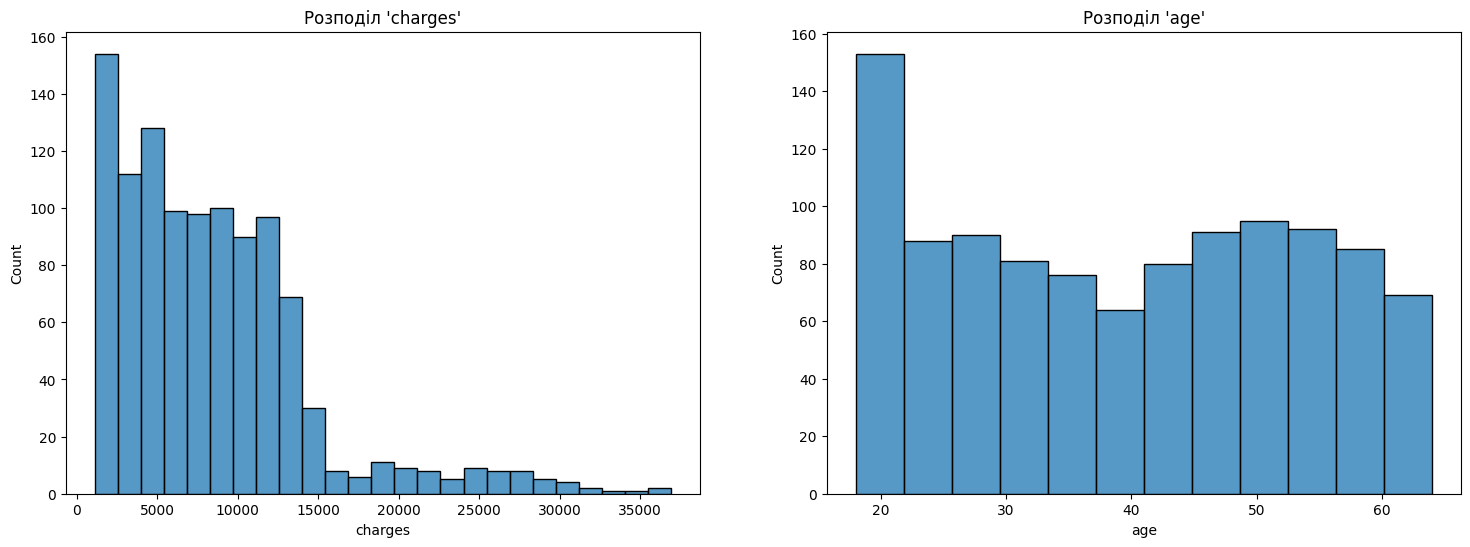

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,6)
ax = sns.histplot(non_smoker_df, x='charges', ax=axes[0])
axes[0].set_title("Розподіл 'charges'")
ax = sns.histplot(non_smoker_df, x='age', ax=axes[1])
axes[1].set_title("Розподіл 'age'");

Бачимо, що charges має скошений розподіл даних. Більшість значень зосереджена в діапазоні значень до 15000. Візуально спостерігається наявність викидів.  

Змінна age має розподіл більше схожий до рівномірного, проте має збільшену кількість спостережень в значенні 20 років, порівнянно з іншими значеннями.  

##Метод найменших квадратів (МНК)

Визначаємо функцію, що порахує коефіцієнти для нашої моделі

In [6]:
def normal_equations(X,y):
    """Computes the closed-form solution to linear regression"""
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [7]:
X_with_intercept = np.c_[np.ones((non_smoker_df.age.shape[0], 1)), non_smoker_df.age]

In [8]:
MNK_coefs = normal_equations(X_with_intercept, non_smoker_df.charges)
MNK_coefs

array([-2091.42055657,   267.24891283])

In [9]:
predictions_MNK = np.dot(X_with_intercept, MNK_coefs)

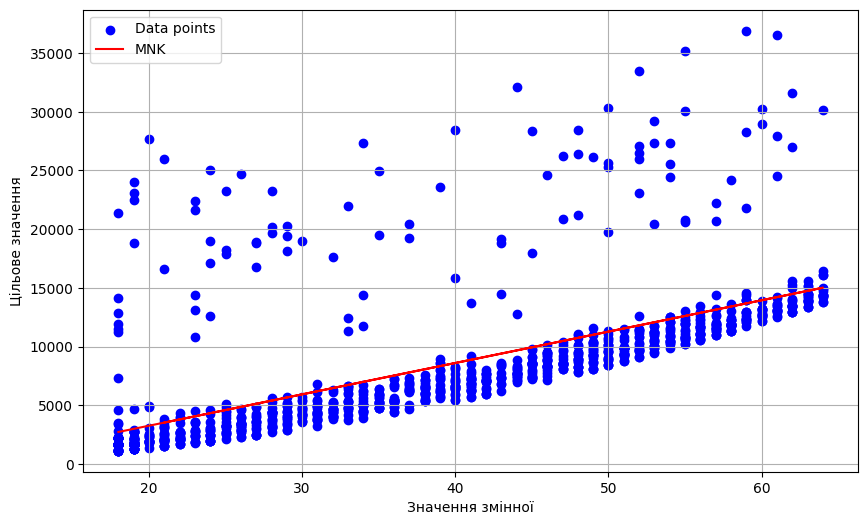

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(non_smoker_df.age, non_smoker_df.charges, color='blue', label='Data points')
plt.plot(non_smoker_df.age, predictions_MNK, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

Між age та charges існує лінійний зв'язок, що чітко видно на графіку. Для перевірки інших припущень лінійної регресії виконаємо перевірку залишків на нормальність та гомоскедастичність.  
Також розрахуємо показники ефективності моделі.

In [11]:
residuals = np.array(non_smoker_df.charges) - predictions_MNK

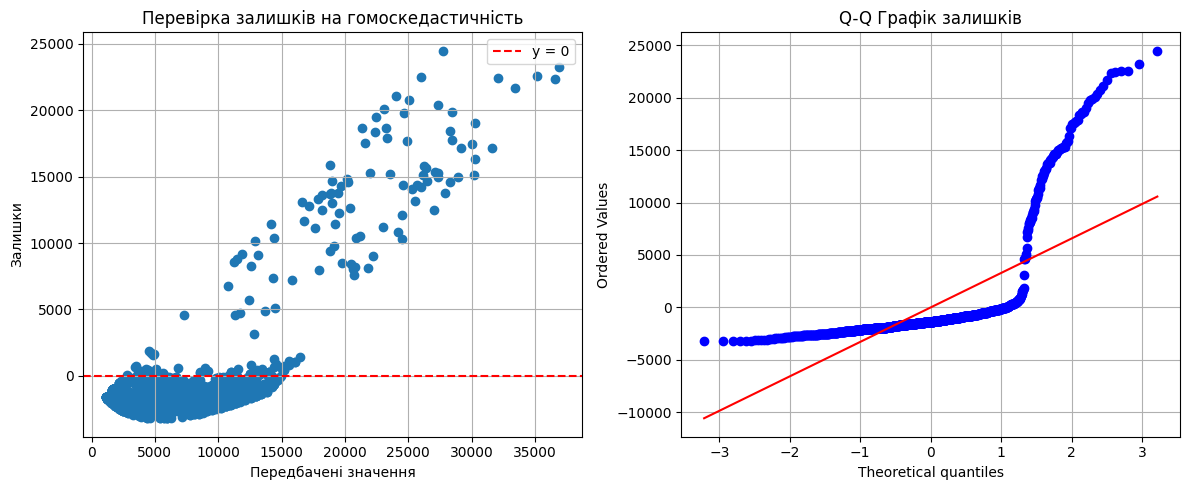

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(non_smoker_df.charges, residuals)
axes[0].axhline(y=0, color='red', linestyle='--', label='y = 0')
axes[0].set_xlabel("Передбачені значення")
axes[0].set_ylabel("Залишки")
axes[0].set_title("Перевірка залишків на гомоскедастичність")
axes[0].legend()
axes[0].grid()
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Графік залишків")
axes[1].grid()
plt.tight_layout()
plt.show()

In [13]:
rmse = np.sqrt(mean_squared_error(non_smoker_df.charges, predictions_MNK)).round(2)
r2 = np.round(r2_score(non_smoker_df.charges, predictions_MNK), 2)
mae = np.round(mean_absolute_error(non_smoker_df.charges, predictions_MNK), 2)
print(f'RMSE = {rmse}\nR2 = {r2}\nMAE = {mae}')

RMSE = 4662.51
R2 = 0.39
MAE = 2580.52


**Висновок:**  
Відповідно до першого графіку можемо зробити висновок, що резидуали є гомоскедастичними.  
Проте, нажаль QQ графік показує, що розподіл залишків не є нормальним, ба більше, він навіть не наближений до нормального.  
**Дії:**  
- Досліджуємо наявність викидів в розподілі резидуалів - викиди в залишках означають, що для певних точок модель дає великі помилки, тобто вони погано описуються регресійною лінією. Це може свідчити про те, що ці точки є аномальними відносно моделі.  
- Якщо викиди присутні, транформуємо наш вхідний датафрейм, доєднавши до нього колонку резидуалів і видалимо всі спостереження, що містять значення резидуалів, які є викидами.  
- Навчимо нашу модель і перевіримо чи змінився розподіл залишків.

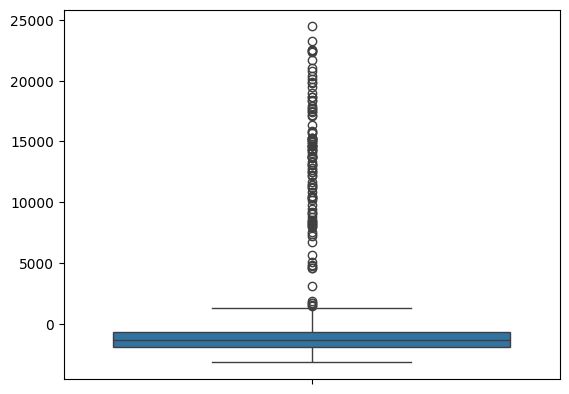

In [14]:
sns.boxplot(residuals);

Відповідно до графіку розподілу резідуалів, маємо викиди.  
Додамо значення резидуалів до нашого датафрейму, розрахуємо значення, що є викидами за допомогою IQR та видалимо спостереження, зі значеннями резидуалів більше IQR

In [15]:
non_smoker_df['residuals_1'] = residuals

In [16]:
Q1 = non_smoker_df['residuals_1'].quantile(0.25)
Q3 = non_smoker_df['residuals_1'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1283.4070009935997


In [17]:
non_smoker_filtered = non_smoker_df[non_smoker_df['residuals_1'] < IQR]

In [18]:
X_with_intercept_filtered = np.c_[np.ones((non_smoker_filtered.age.shape[0], 1)), non_smoker_filtered.age]

In [19]:
MNK_coefs_filtered = normal_equations(X_with_intercept_filtered, non_smoker_filtered.charges)
MNK_coefs_filtered

array([-3613.90525263,   270.13130651])

In [20]:
predictions_MNK_filtered = np.dot(X_with_intercept_filtered, MNK_coefs_filtered)

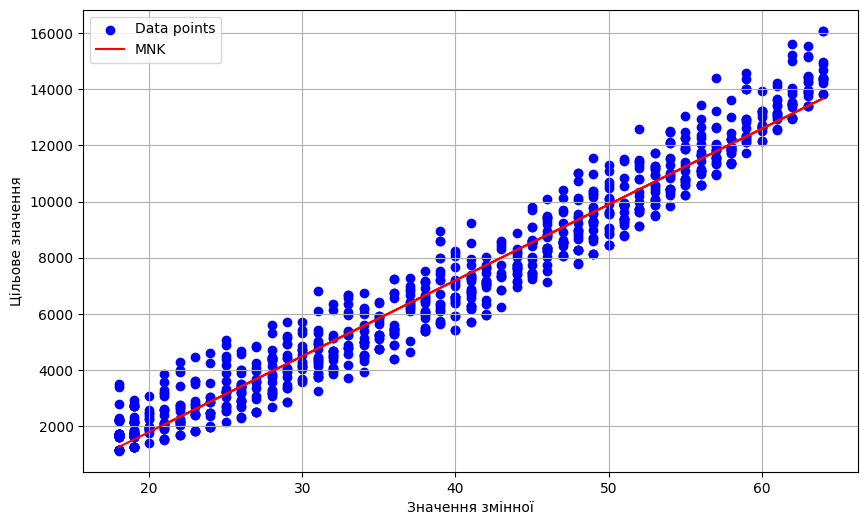

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(non_smoker_filtered.age, non_smoker_filtered.charges, color='blue', label='Data points')
plt.plot(non_smoker_filtered.age, predictions_MNK_filtered, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
residuals_2 = np.array(non_smoker_filtered.charges) - predictions_MNK_filtered

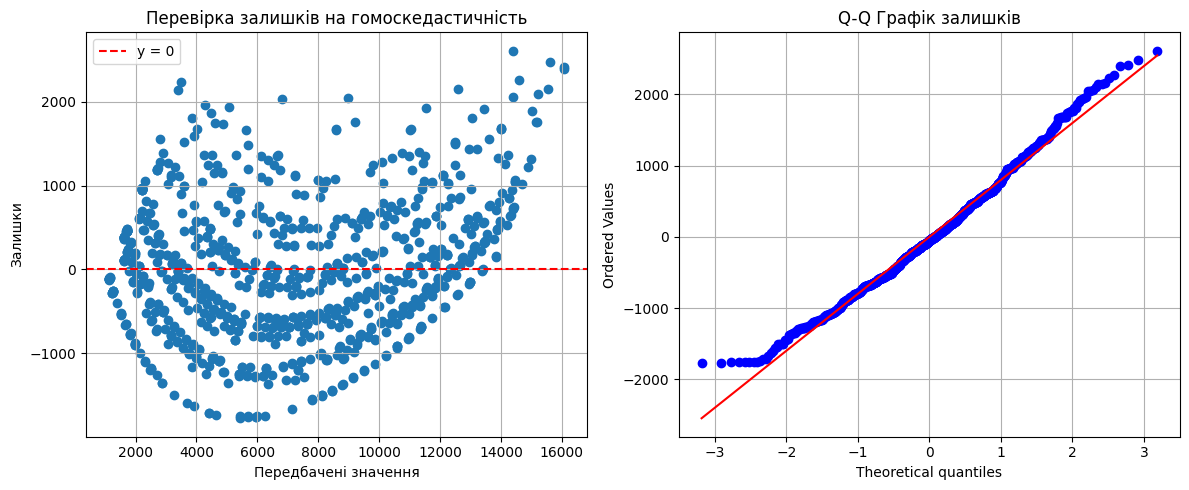

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(non_smoker_filtered.charges, residuals_2)
axes[0].axhline(y=0, color='red', linestyle='--', label='y = 0')
axes[0].set_xlabel("Передбачені значення")
axes[0].set_ylabel("Залишки")
axes[0].set_title("Перевірка залишків на гомоскедастичність")
axes[0].legend()
axes[0].grid()
stats.probplot(residuals_2, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Графік залишків")
axes[1].grid()
plt.tight_layout()
plt.show()

Отримані результати візуально задовільняють припущенням лінійної регресії:  
- розподіл наближений до нормального  
- присутня гомоскедастичність  

Проте, тепер важливо перевірити, як модель, тренована на фільтрованих даних, буде робити передбачення на повному наборі даних.

In [24]:
predictions_X_origin_MNK_filtered = np.dot(X_with_intercept, MNK_coefs_filtered)

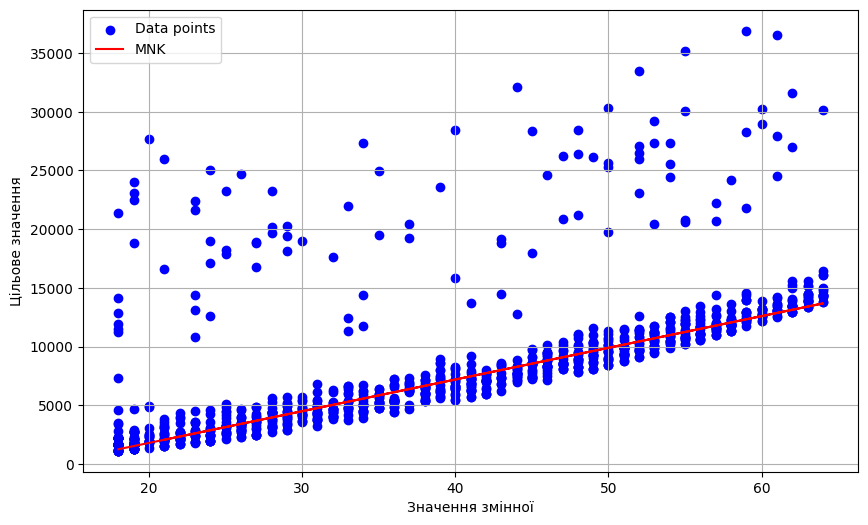

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(non_smoker_df.age, non_smoker_df.charges, color='blue', label='Data points')
plt.plot(non_smoker_df.age, predictions_X_origin_MNK_filtered, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

Розрахуємо показники якості моделі

In [26]:
rmse_X_origin_MNK_filtered = np.sqrt(mean_squared_error(non_smoker_df.charges, predictions_X_origin_MNK_filtered)).round(2)
r2_X_origin_MNK_filtered = np.round(r2_score(non_smoker_df.charges, predictions_X_origin_MNK_filtered), 2)
mae_X_origin_MNK_filtered = np.round(mean_absolute_error(non_smoker_df.charges, predictions_X_origin_MNK_filtered), 2)
print(f'RMSE = {rmse_X_origin_MNK_filtered}\nR2 = {r2_X_origin_MNK_filtered}\nMAE = {mae_X_origin_MNK_filtered}')

RMSE = 4870.91
R2 = 0.34
MAE = 1983.42


**Висновок:**  
По показникам rmse, r2 модель, тренована на фільтрованих даних демонструє гірші показники, проте показник mae в такої моделі значно менше.  
Враховуючи розподіл charges для не курців, де більшість спостережень зосереджено в діапазоні до 15000, більш низький показник mae є більш пріоритетним, оскільки модель значно краще передбачає значення таргет змінної з невеликими значеннями, отже вона краще передбачить значення для більшої кількості наших клієнтів. Крім того, саме для моделі, тренованої на фільтрованих даних у нас виконуються всі припущення лінійної регресії.  
Отже, виглядає так, що модель тренована на фільтрованих даних є кращою в нашому конкретному випадку.

Проте, спробуємо використати інші методи, модифікувати вхідні значення chagres і подивитись на отримані результати, щоб обрати оптимальний варіант моделі.  

Застосуємо метод логарифмування, оскільки початковий розподіл charges має "хвіст" у бік більший значень.

In [27]:
non_smoker_df['charges_lg'] = np.log(non_smoker_df['charges'] + 1)

In [28]:
MNK_coefs_lg = normal_equations(X_with_intercept, non_smoker_df.charges_lg)
MNK_coefs_lg

array([7.13430829, 0.04199857])

In [29]:
predictions_MNK_lg = np.dot(X_with_intercept, MNK_coefs_lg)

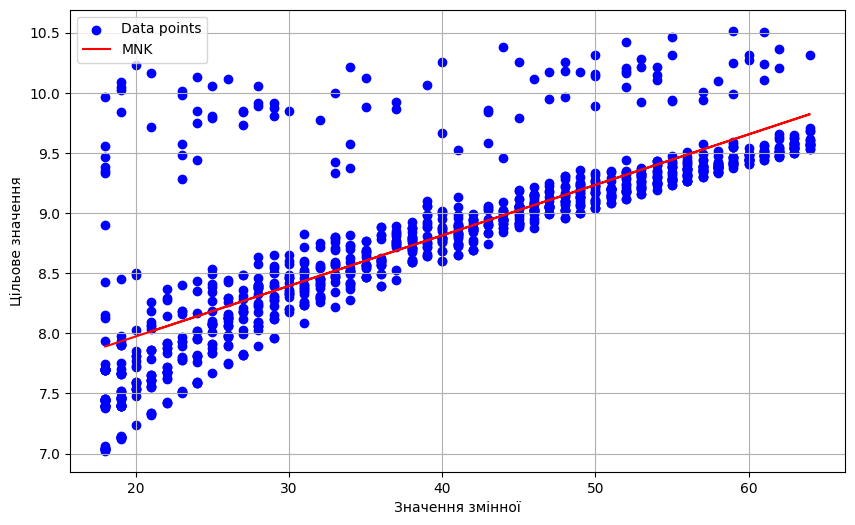

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(non_smoker_df.age, non_smoker_df.charges_lg, color='blue', label='Data points')
plt.plot(non_smoker_df.age, predictions_MNK_lg, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
residuals_lg = np.array(non_smoker_df.charges_lg) - predictions_MNK_lg

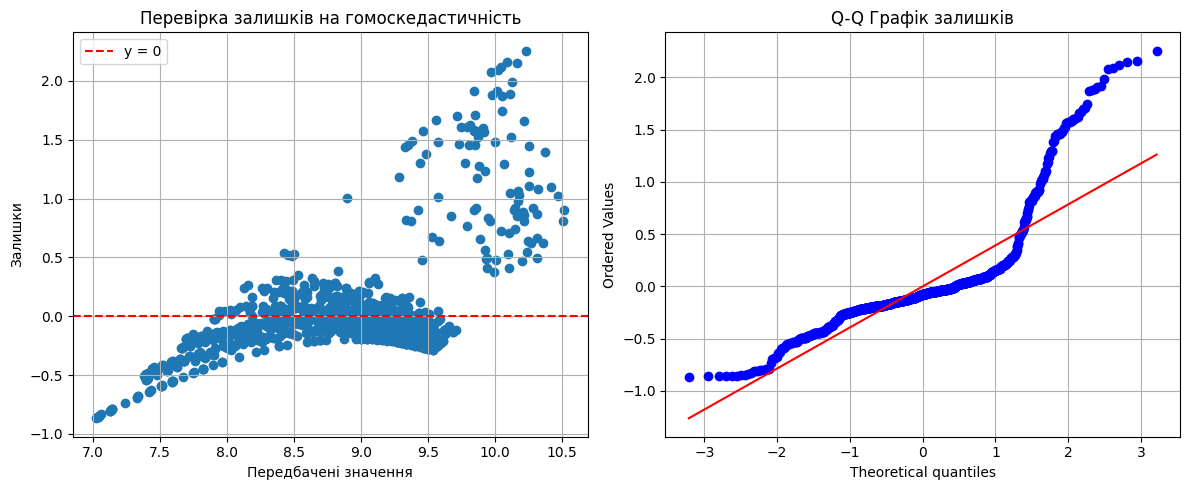

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(non_smoker_df.charges_lg, residuals_lg)
axes[0].axhline(y=0, color='red', linestyle='--', label='y = 0')
axes[0].set_xlabel("Передбачені значення")
axes[0].set_ylabel("Залишки")
axes[0].set_title("Перевірка залишків на гомоскедастичність")
axes[0].legend()
axes[0].grid()
stats.probplot(residuals_lg, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Графік залишків")
axes[1].grid()
plt.tight_layout()
plt.show()

In [33]:
predictions_MNK_lg_original = np.exp(predictions_MNK_lg) - 1

In [34]:
rmse_lg = np.sqrt(mean_squared_error(non_smoker_df.charges, predictions_MNK_lg_original)).round(2)
r2_lg = r2_lg = np.round(r2_score(non_smoker_df.charges, predictions_MNK_lg_original), 2)
mae_lg = np.round(mean_absolute_error(non_smoker_df.charges, predictions_MNK_lg_original), 2)
print(f'RMSE = {rmse_lg}\nR2 = {r2_lg}\nMAE = {mae_lg}')

RMSE = 4767.2
R2 = 0.37
MAE = 2294.06


**Висновок:**  
Розподіл резидуалів менше походить до нормального, гомоскедастичність присутня, показники rmse, r2 є трохи кращими за попередню модель, проте mae має більше значення ніж в попередньої моделі.   
**Дії:**  
Спробуємо тепер метод зворотньої залежності

In [35]:
epsilon = 1e-6
non_smoker_df['charges_inverse'] = 1 / (non_smoker_df['charges'] + epsilon)


In [36]:
MNK_coefs_inverse = normal_equations(X_with_intercept, non_smoker_df.charges_inverse)
MNK_coefs_inverse

array([ 5.65820187e-04, -9.19780985e-06])

In [37]:
predictions_MNK_inverse = np.dot(X_with_intercept, MNK_coefs_inverse)

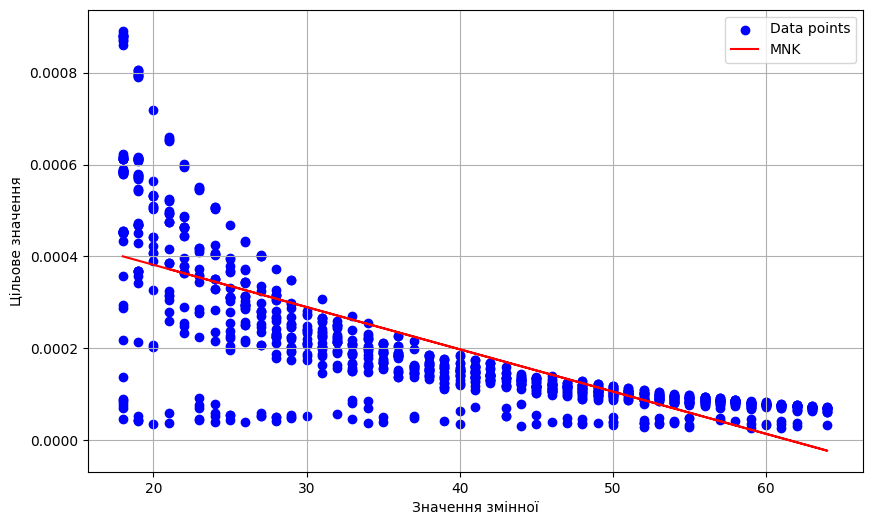

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(non_smoker_df.age, non_smoker_df.charges_inverse, color='blue', label='Data points')
plt.plot(non_smoker_df.age, predictions_MNK_inverse, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
residuals_inv = np.array(non_smoker_df.charges_inverse) - predictions_MNK_inverse

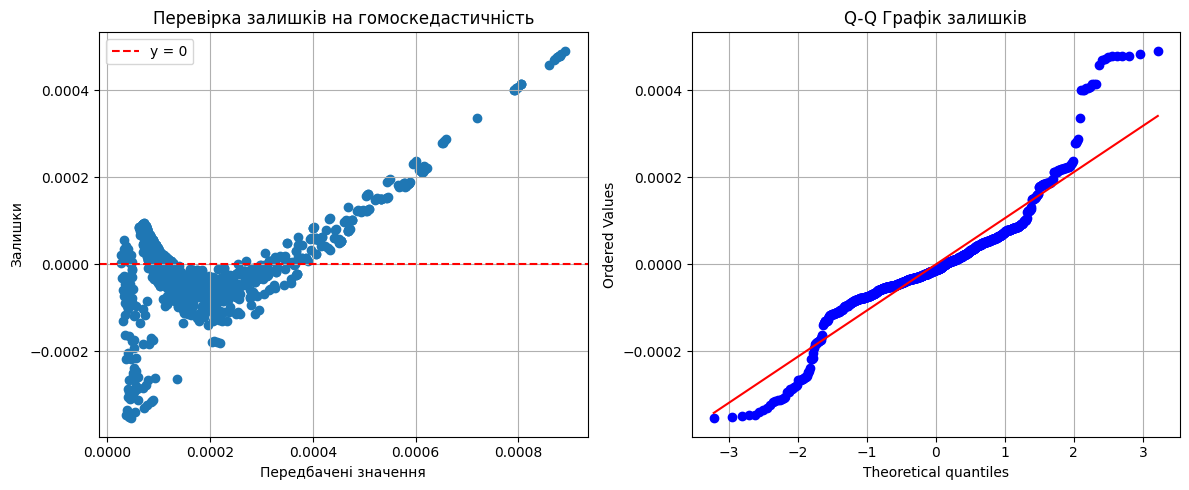

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(non_smoker_df.charges_inverse, residuals_inv)
axes[0].axhline(y=0, color='red', linestyle='--', label='y = 0')
axes[0].set_xlabel("Передбачені значення")
axes[0].set_ylabel("Залишки")
axes[0].set_title("Перевірка залишків на гомоскедастичність")
axes[0].legend()
axes[0].grid()
stats.probplot(residuals_inv, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Графік залишків")
axes[1].grid()
plt.tight_layout()
plt.show()

Розподіл залишків все ще не є нормальним, втрачено гомоскедастичність

###Висновок:  
За результатами оцінки моделей можна зробити припущення, що доцільніше обрати модель, навчену на фільтрованих даних:
- вона відповідає припущенням лінійної регресії
- вона має нижче значення mae. Враховуючи розподіл charges для не курців, де більшість спостережень зосереджено в діапазоні до 15000, більш низький показник mae є більш пріоритетним, оскільки модель значно краще передбачає значення таргет змінної з невеликими значеннями, отже вона краще передбачить значення для більшої кількості наших клієнтів.  

##Метод Full-Batch градієнтного спуску

Визначаємо функцію, для розрахунку коефіцієнтів за графієнтним спуском

In [41]:
def full_batch_gradient_descent(X, y, lr=0.1, epochs=100):
    m, b = 0.0, 0.0
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors


In [42]:
def coef_pred_metric_plot(X, y, lr=0.01, epochs=100):
    m, b, errors = full_batch_gradient_descent(X, y, lr=lr, epochs=epochs)
    print(f'Коефіцієнти: m = {m}, b = {b}')

    predictions_fbgd = m * X[:, 0] + b

    rmse_fbgd = np.sqrt(mean_squared_error(y, predictions_fbgd)).round(2)
    r2_fbgd = np.round(r2_score(y, predictions_fbgd), 2)
    mae_fbgd = np.round(mean_absolute_error(y, predictions_fbgd), 2)
    print(f'RMSE = {rmse_fbgd}\nR2 = {r2_fbgd}\nMAE = {mae_fbgd}')

    plt.plot(errors)
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Error Reduction over Time')
    plt.show()
    return predictions_fbgd, rmse_fbgd, r2_fbgd, mae_fbgd, m, b


In [43]:
X = np.expand_dims(np.array(non_smoker_df.age), axis=1)

Коефіцієнти: m = 221.1045843794301, b = -41.98126853149978
RMSE = 4713.25
R2 = 0.38
MAE = 2803.85


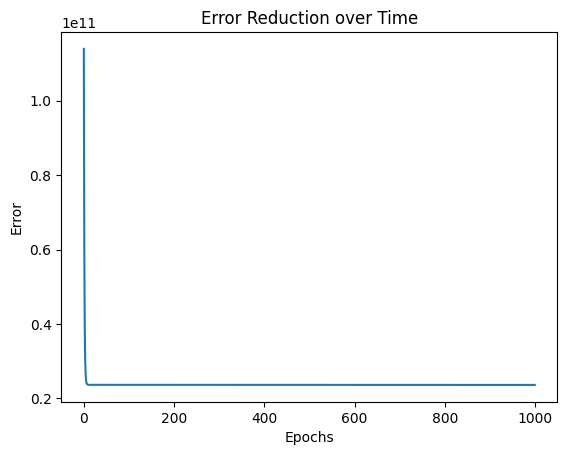

In [44]:
predictions_fbgd_0001, rmse_fbgd_0001, r2_fbgd_0001, mae_fbgd_0001, m_0001, b_0001 = coef_pred_metric_plot(X, non_smoker_df.charges, lr=0.0001, epochs=1000)

Розмір помилки різко впав ще на перших ітераціях, проте після цього залишився однаковим на протязі всіх наступних ітерацій. Крім того, оцінки якості моделі свідчать про низьку точність моделі.  
Спробуємо збільшити learning rate.  

In [45]:
predictions_fbgd_001, rmse_fbgd_001, r2_fbgd_001, mae_fbgd_001, m_001, b_001 = coef_pred_metric_plot(X, non_smoker_df.charges, lr=0.001, epochs=1000)

<ipython-input-41-8aa6cda3c4b3>:11: RuntimeWarning: invalid value encountered in scalar subtract
  m = m - lr * m_gradient


Коефіцієнти: m = nan, b = inf


ValueError: Input contains NaN.

Збільшення learning rate призвело до помилки через те, що значення аргументів отримали Nan значення. Можливо через те, що таргет змінна та незалежна змінна мають різний порядок величин.  
Нормалізуємо наші значення та ще раз подивимось на поведінку наших помилок.  
Також змінемо визначену функцію, щоб зробити її уніфікованою.

In [46]:
def coef_pred_metric_plot(X, y, lr=0.01, epochs=100, normalize=False):
    if normalize:
        X_normal = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        y_normal = (y - np.mean(y)) / np.std(y)
    else:
        X_normal, y_normal = X, y

    m, b, errors = full_batch_gradient_descent(X_normal, y_normal, lr=lr, epochs=epochs)
    print(f'Коефіцієнти: m = {m}, b = {b}')

    predictions_fbgd = m * X_normal[:, 0] + b

    if normalize:
        predictions_fbgd = predictions_fbgd * np.std(y) + np.mean(y)

    rmse_fbgd = np.sqrt(mean_squared_error(y, predictions_fbgd)).round(2)
    r2_fbgd = np.round(r2_score(y, predictions_fbgd), 2)
    mae_fbgd = np.round(mean_absolute_error(y, predictions_fbgd), 2)
    print(f'RMSE = {rmse_fbgd}\nR2 = {r2_fbgd}\nMAE = {mae_fbgd}')

    plt.plot(errors)
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Error Reduction over Time')
    plt.show()
    return predictions_fbgd, rmse_fbgd, r2_fbgd, mae_fbgd, m, b

Коефіцієнти: m = 0.5431334512950768, b = -2.1148997340370743e-16
RMSE = 4690.11
R2 = 0.39
MAE = 2627.67


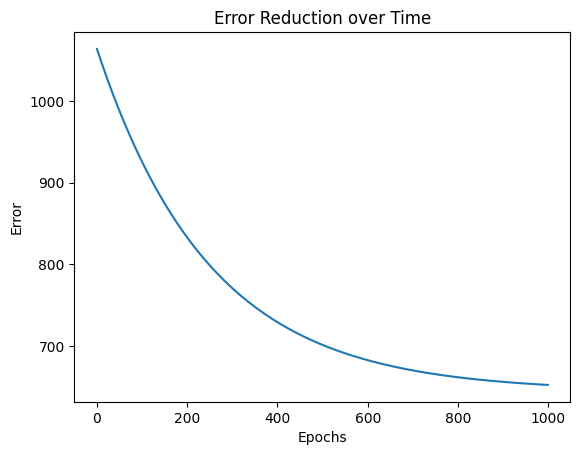

In [47]:
predictions_fbgd_normal_001, rmse_fbgd_001, r2_fbgd_001, mae_fbgd_001, m_001, b_001 = coef_pred_metric_plot(X, non_smoker_df.charges, lr=0.001, epochs=1000, normalize=True)

Відзначаємо, що показники якості моделі покращились. Помилка зменшується на протязі всіх епох.  
Спробуємо ще збільшити learning rate до 0.01

Коефіцієнти: m = 0.6279467827096055, b = -2.772886348270564e-16
RMSE = 4662.51
R2 = 0.39
MAE = 2580.52


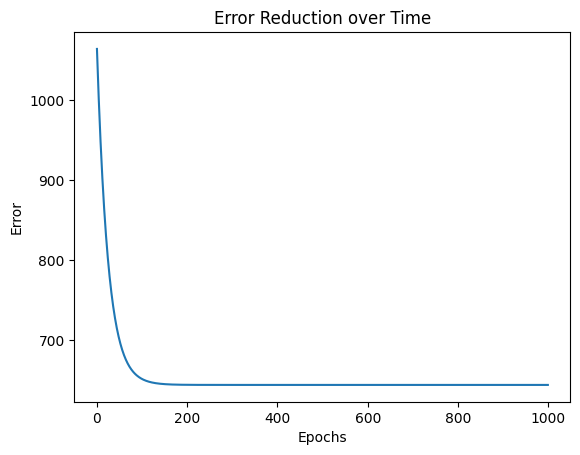

In [48]:
predictions_fbgd_normal_01, rmse_fbgd_01, r2_fbgd_01, mae_fbgd_01, m_01, b_01 = coef_pred_metric_plot(X, non_smoker_df.charges, lr=0.01, epochs=1000, normalize=True)

Відзначаємо ще деяке покращення метрик оцінки якості моделі. Проте, вони ще досі залишаються великими в частині розміру помилок, та значення r2 залишається не достатньо високим.   
Це може свідчити про те, що змінна age не має суттєвого впливу на розмір charges.  
Однак, остання модель показала найкращі показники серед натренованих за допомогою градієнтного спуску.

##scikit-learn.LinearRegression

З scikit-learn.LinearRegression. Тут зверніть увагу, що вхід X має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись X.to_frame() щоб конвертувати колонку в датафрейм.

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
lin_reg = LinearRegression()
lin_reg.fit(X, non_smoker_df.charges)
print(lin_reg.coef_, lin_reg.intercept_)
predictions_sklearn = lin_reg.predict(X)

[267.24891283] -2091.4205565650864


In [51]:
rmse_sklearn = np.sqrt(mean_squared_error(non_smoker_df.charges, predictions_sklearn)).round(2)
r2_sklearn = np.round(r2_score(non_smoker_df.charges, predictions_sklearn), 2)
mae_sklearn = np.round(mean_absolute_error(non_smoker_df.charges, predictions_sklearn), 2)
print(f'RMSE = {rmse_sklearn}\nR2 = {r2_sklearn}\nMAE = {mae_sklearn}')

RMSE = 4662.51
R2 = 0.39
MAE = 2580.52


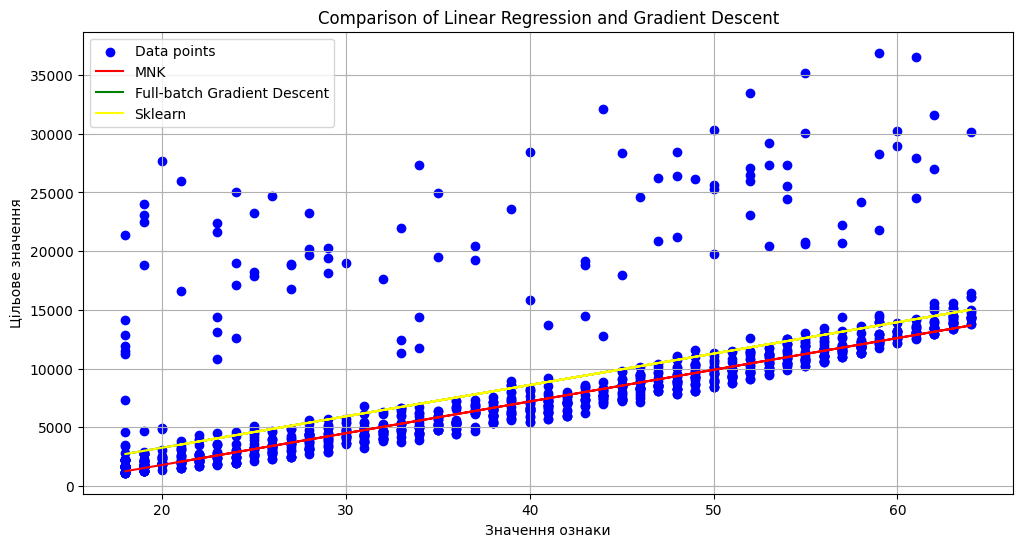

In [52]:
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], non_smoker_df.charges, color='blue', label='Data points')
plt.plot(X[:, 0], predictions_X_origin_MNK_filtered, color='red', label='MNK')
plt.plot(X[:, 0], predictions_fbgd_normal_01, color='green', label='Full-batch Gradient Descent')
plt.plot(X[:, 0], predictions_sklearn, color='yellow', label='Sklearn')
plt.title('Comparison of Linear Regression and Gradient Descent')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
print(f'MNK коефіцієнти: {MNK_coefs_filtered}')
print(f'FBGD коефіцієнти: {m_01, b_01}')
print(f'sklearn коефіцієнти: {lin_reg.coef_, lin_reg.intercept_}')

MNK коефіцієнти: [-3613.90525263   270.13130651]
FBGD коефіцієнти: (0.6279467827096055, -2.772886348270564e-16)
sklearn коефіцієнти: (array([267.24891283]), -2091.4205565650864)


In [54]:
print(f'Параметри якості моделей:')
print(f'Метод найменших квадратів:\nRMSE = {rmse_X_origin_MNK_filtered}\nR2 = {r2_X_origin_MNK_filtered}\nMAE = {mae_X_origin_MNK_filtered}\n'
      f'Градієнтний спуск:\nRMSE = {rmse_fbgd_01}\nR2 = {r2_fbgd_01}\nMAE = {mae_fbgd_01}\n'
      f'Лінійна регресія з sklearn:\nRMSE = {rmse_sklearn}\nR2 = {r2_sklearn}\nMAE = {mae_sklearn}\n')

Параметри якості моделей:
Метод найменших квадратів:
RMSE = 4870.91
R2 = 0.34
MAE = 1983.42
Градієнтний спуск:
RMSE = 4662.51
R2 = 0.39
MAE = 2580.52
Лінійна регресія з sklearn:
RMSE = 4662.51
R2 = 0.39
MAE = 2580.52



##Висновок:  
На графіку видно, що лінії передбачених значень для моделі, тренованої методом градієнтного спуску, і моделі, тренованої за допомогою бібліотеки sklearn, накладаються одна на одну. Це свідчить про те, що обидві моделі дали однакові значення передбачень.

Ці дві моделі також мають однакові метрики оцінки якості моделі.

Водночас, спостерігається складність із повним виконанням припущень лінійної регресії, зокрема нормальність розподілу залишків. У такій ситуації моделі, треновані методом градієнтного спуску та за допомогою бібліотеки sklearn, демонструють кращі результати, оскільки обидві методики менш критичні до порушення припущень лінійної регресії порівняно з методом найменших квадратів.

Однак, низьке значення 𝑅2 у всіх моделях свідчить про те, що age має недостатній вплив на цільову змінну charges. Це може вказувати на необхідність додавання інших змінних для покращення моделі.

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [55]:
smoker_df = df[df.smoker == 'yes'].copy()

Візуалізуємо розподіли Таргет змінної charges та незалежної змінної age серед курців

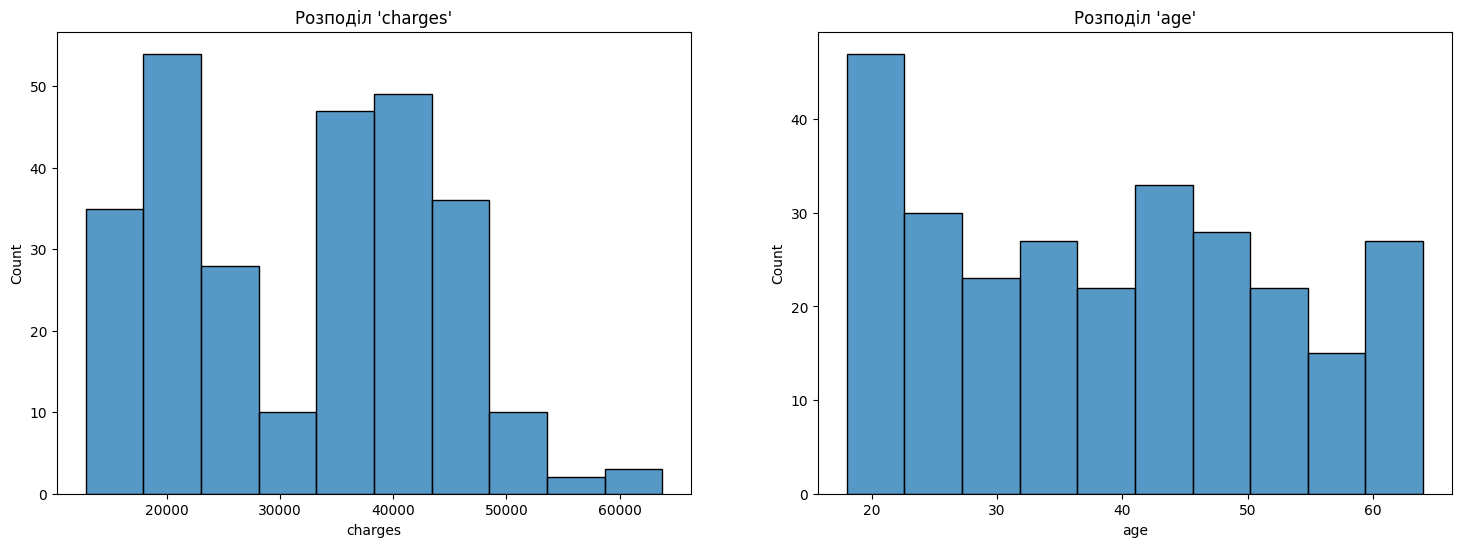

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,6)
ax = sns.histplot(smoker_df, x='charges', ax=axes[0])
axes[0].set_title("Розподіл 'charges'")
ax = sns.histplot(smoker_df, x='age', ax=axes[1])
axes[1].set_title("Розподіл 'age'");

In [57]:
X = np.expand_dims(np.array(smoker_df.age), axis=1)

In [58]:
lin_reg_smoker = LinearRegression()
lin_reg_smoker.fit(X, smoker_df.charges)
print(lin_reg.coef_, lin_reg.intercept_)
predictions_sklearn_smokers = lin_reg_smoker.predict(X)

[267.24891283] -2091.4205565650864


In [59]:
rmse_sklearn_smokers = np.sqrt(mean_squared_error(smoker_df.charges, predictions_sklearn_smokers)).round(2)
r2_sklearn_smokers = np.round(r2_score(smoker_df.charges, predictions_sklearn_smokers), 2)
mae_sklearn_smokers = np.round(mean_absolute_error(smoker_df.charges, predictions_sklearn_smokers), 2)
print(f'RMSE = {rmse_sklearn_smokers}\nR2 = {r2_sklearn_smokers}\nMAE = {mae_sklearn_smokers}')

RMSE = 10711.0
R2 = 0.14
MAE = 10097.8


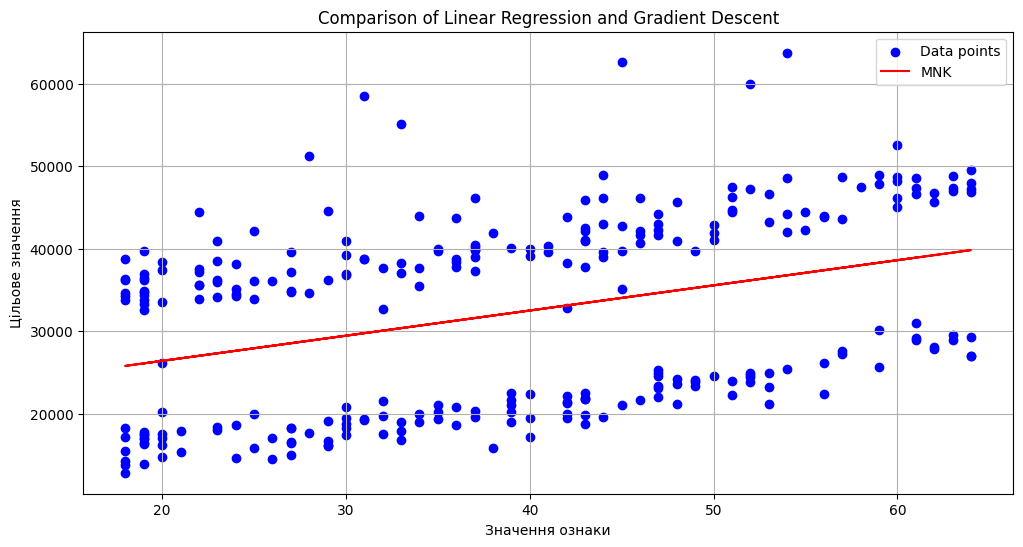

In [60]:
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], smoker_df.charges, color='blue', label='Data points')
plt.plot(X[:, 0], predictions_sklearn_smokers, color='red', label='MNK')
plt.title('Comparison of Linear Regression and Gradient Descent')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

##Висновок:  
Відповідно до отриманих результатів, модель показує низькі параметри оцінки якості, що свідчить про дуже низьку здатність моделі робити точні передбачення.  
Я би не стала використовувати дану модель в компанії.